# Lab 3: Geostatistical simulation

## Your name here: Sean Hamilton

In this lab, you will compute the variogram for your radar topography measurements, which describes its roughness. 

Refer to the Scikit-Gstat and GStatSim Jupyter Book tutorials for guidance: 

https://gatorglaciology.github.io/gstatsimbook/intro.html 

https://scikit-gstat.readthedocs.io/en/latest/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import skgstat as skg
from sklearn.preprocessing import QuantileTransformer
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gstatsim as gs

### First, load your radar data from Lab 1. 

If you did not save a csv file with your radar bed measurements, you can do that by re-running the radar data cropping section in Lab 1 and saving a csv file. Alternatively, you can load and crop the radar data here using your domain coordinates. 

Remember, you will need to save the bed elevation, not ice thickness, by subtracting thickness from the ice surface. In Lab1, this was done in this line: df['bed'] = df['surf'].values - radar_thickness.flatten()

So save a csv with df['bed'] and the coordinates.

Make sure to drop any rows with NaN values. You can do that with df = df.dropna()

In [2]:
df_bed = pd.read_csv('../data/KohlerPopeSmith.csv')
df_bed = df_bed[['x', 'y', 'bed']]
df_bed.head()
#NOTE Only 72,957 rows out of 250,000 that aren't NA! 
#     This causes problems when sampling points for generating a variogram.
df_bed = df_bed[~df_bed['bed'].isna()] # Drop na bed values

Now let's plot your data. You'll want to change vmin and vmax to suit your data range.

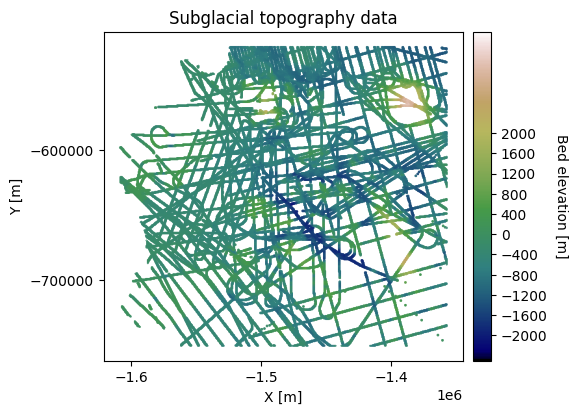

In [3]:
# plot data
fig = plt.figure(figsize = (5,5))
ax = plt.gca()
im = ax.scatter(df_bed['x'], df_bed['y'], c=df_bed['bed'], vmin=-2500, vmax=4000, 
                     marker='.', s=0.5, cmap='gist_earth')
plt.title('Subglacial topography data')
plt.xlabel('X [m]'); plt.ylabel('Y [m]')
plt.locator_params(nbins=5)
plt.axis('scaled')

# make colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-2000, 2000, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)
plt.show()

### Normal score transformation

Geostatistical methods typically require Gaussian assumptions, so we need to perform a normal score transformation to convert to a standard Gaussian distribution (mean = 0, standard deviaton = 1, Gaussian shape). After performing a geostatistical interpolation, we will back-transform the interpolation to recover the original distribution.

In [4]:
# normal score transformation
data = df_bed['bed'].values.reshape(-1,1)
nst_trans = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(data)
df_bed['Nbed'] = nst_trans.transform(data) 

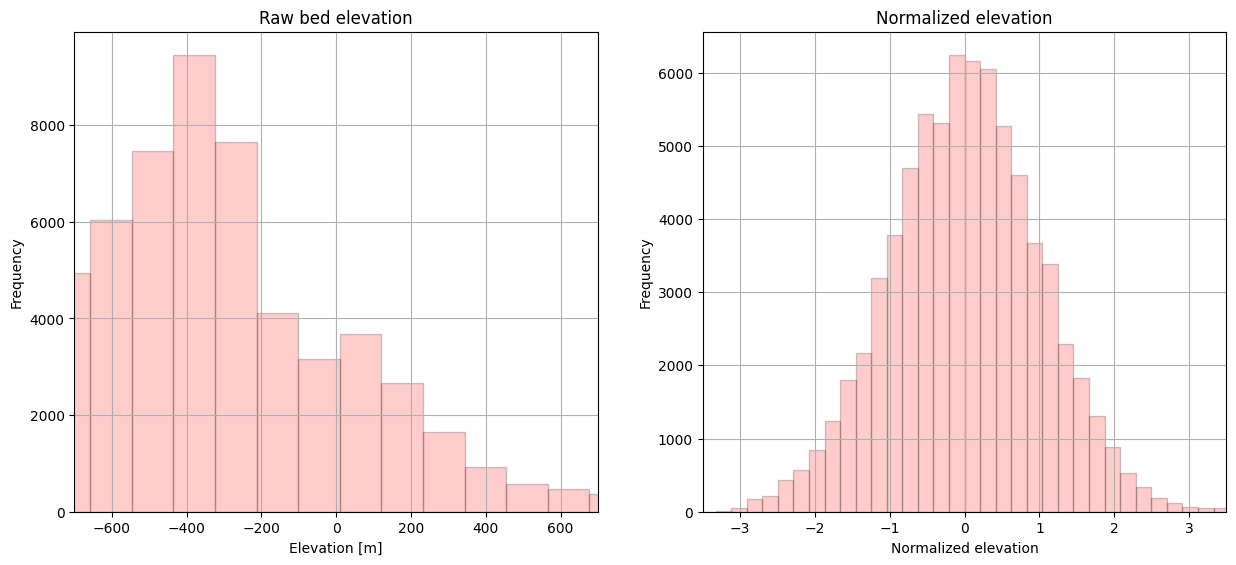

In [5]:
# plot original bed histogram
plt.subplot(121)
plt.hist(df_bed['bed'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([-700,700]); 
plt.xlabel('Elevation [m]'); plt.ylabel('Frequency'); plt.title('Raw bed elevation')
plt.grid(True)

# plot normal score bed histogram (with weights)
plt.subplot(122)
plt.hist(df_bed['Nbed'], facecolor='red', bins=50, alpha=0.2, edgecolor='black')
plt.xlim([-3.5,3.5]); 
plt.xlabel('Normalized elevation'); plt.ylabel('Frequency'); plt.title('Normalized elevation')
plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.8, top=1.0, wspace=0.2, hspace=0.3)
plt.show()

__Q1: How do the before and after transformation histograms compare? Why is this step important?__

Answer: The histogram before the transformation goes from skewed to the right to then having a bell-curve characteristic of a Normal distribution after the Normal score transformation. This step is important because for geostatistical methods like SGS, we need to assume that the distribution is Normal. This is to satisfy Gaussian assumptions as stated earlier in this notebook. 

### Compute the experimental variogram

The variogram is how we "learn" the roughness of the topography.

When computing the variogram, we'll randomly drop out a fraction of the points to speed up the variogram calculation. Don't worry, the variogram will still be fairly robust. You might need to play around with this percentage, depending on how much data you have.

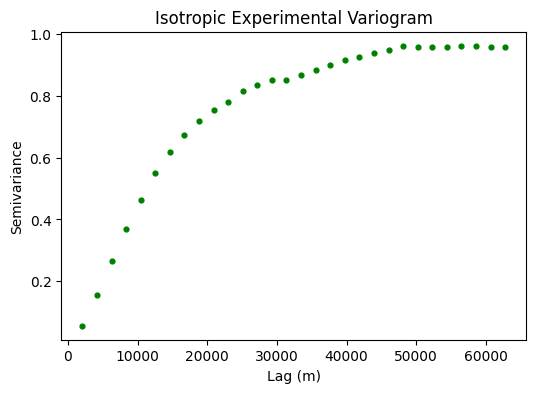

In [6]:
# randomly drop out 50% of coordinates. Decrease this value if you have a lot of data and it takes a long time to run
df_sampled = df_bed.sample(frac=0.35, random_state=42)

# compute experimental (isotropic) variogram
coords = df_sampled[['x','y']].values
values = df_sampled['Nbed']

maxlag = coords.ptp(axis=0).max() * 0.25      # maximum range distance. Limit to a quarter of the domain
n_lags = 30         # num of bins (try decreasing if this is taking too long)

# compute variogram
V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags, maxlag=maxlag, normalize=False)

# extract variogram values
xdata = V1.bins
ydata = V1.experimental

plt.figure(figsize=(6,4))
plt.scatter(xdata, ydata, s=12, c='g')
plt.title('Isotropic Experimental Variogram')
plt.xlabel('Lag (m)'); plt.ylabel('Semivariance')
plt.show()

__Q2: By looking at your variogram model, roughly what is your sill and range? What do these parameters represent? Why does the semivariance axis go up to ~1?__

Answer: The sill is around 0.95 and the range seems to be 45,000. The sill represents the limit of the variogram's variance as lag goes to infinity and the range represents the distance at which points are no longer spatially correlated. The semivariance axis goes up to around one because of the Normalalization we performaed on the bed elevation data. By normalizing the elevation, we give our data a mean of 1, which we can see as the middle of the bell-curve in the plot of the normalized elevation. 

### Fit variogram model

Now we need to fit variogram model parameters to the experimental variogram. We will use these model parameters when we perform our simulations.

There are many different variogram model types. We will use the Matern variogram because it has an extra parameter which helps the model fit extra well, and I think this model type tends to produce the most believable looking topography.

Read up on variogram modeling here: https://scikit-gstat.readthedocs.io/en/latest/auto_examples/tutorial_03_variogram_models.html#sphx-glr-auto-examples-tutorial-03-variogram-models-py 

In [7]:
# use matern variogram model
V1.model = 'matern' 
V1.parameters

[37055.66482744813, 0.9620360845215784, 0.824604029114109, 0]

__Q3: Describe each parameter? How does this compare to your guess in Q2?__

Answer: The parameters in order of how the appear in the output of the last cell are range, sill, smootheness, and nugget. Our guess for the range was off by nearly 10,000 as it seems the increase in variance after that point was deemed negligible by skgs package. Our guess for the sill was very close. We did not make a guess for the third parameter, smoothness, and we assumed that the nugget was zero, which it is. 

In [8]:
# evaluate models
xi =np.linspace(0, xdata[-1], 100) 

y_matern = skg.models.matern(xi, V1.parameters[0], V1.parameters[1], V1.parameters[2], V1.parameters[3])


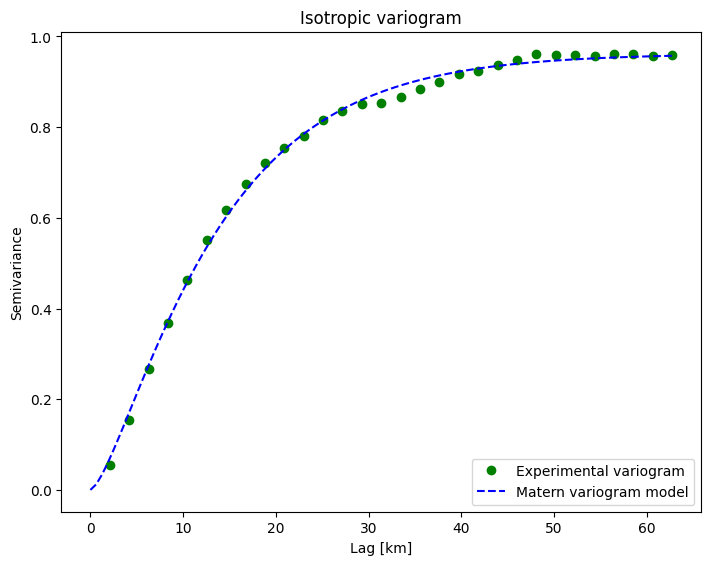

In [9]:
# plot variogram model
fig = plt.figure()
plt.plot(xdata/1000,ydata,'og', label = "Experimental variogram")
plt.plot(xi/1000, y_matern,'b--', label='Matern variogram model')
plt.title('Isotropic variogram')
plt.xlabel('Lag [km]'); plt.ylabel('Semivariance')  
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1.0) # adjust the plot size
plt.legend(loc='lower right')

### Now that we have our variogram parameters, we can move on to simulation

First, we need to initialize a simulation grid. This will ensure your data is properly gridded. 

In [10]:
# grid data to 500 m resolution and remove coordinates with NaNs
res = 2000
df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'x', 'y', 'Nbed', res)
df_grid = df_grid[df_grid["Z"].isnull() == False]
df_grid = df_grid.rename(columns = {"Z": "Nbed"}) # rename last column

# define coordinate grid
xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

pred_grid = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)

In [11]:
df_grid.head()

,X,Y,Sum,Count,Nbed
24,-1560750.0,-750750.0,3.012886,9.0,0.334765
26,-1556750.0,-750750.0,0.221464,1.0,0.221464
27,-1554750.0,-750750.0,2.577929,8.0,0.322241
28,-1552750.0,-750750.0,0.675445,2.0,0.337722
30,-1548750.0,-750750.0,1.251569,9.0,0.139063


Let's set up our simulation. We'll need the variogram parameters, and we als oneed to decide our number of nearest neighboring conditioning points and search radius.

In [12]:
# save variogram parameters as a list
azimuth = 0
nugget = 0 # make nugget 0

# the major and minor ranges are the same in this example because it is isotropic
major_range = V1.parameters[0]
minor_range = V1.parameters[0]
sill = V1.parameters[1]
smoothness = 2.5 # V1.parameters[2] # Use higher smoothness parameter
vtype = 'matern'
vario_list = [azimuth, nugget, major_range, minor_range, sill, 'matern', smoothness]

k = 48         # number of neighboring data points used to estimate a given point 
rad = 80000    # 70 km search radius

sim = gs.Interpolation.okrige_sgs(pred_grid, df_grid, 'X', 'Y', 'Nbed', k, vario_list, rad, quiet=False, seed=0)
sim_trans = nst_trans.inverse_transform(sim.reshape(-1,1)).squeeze() # back transformation

100%|██████████| 14490/14490 [01:02<00:00, 233.09it/s]


This might take a while! While you are working on the code, you might want to temporarily coarsen the resolution to save time.

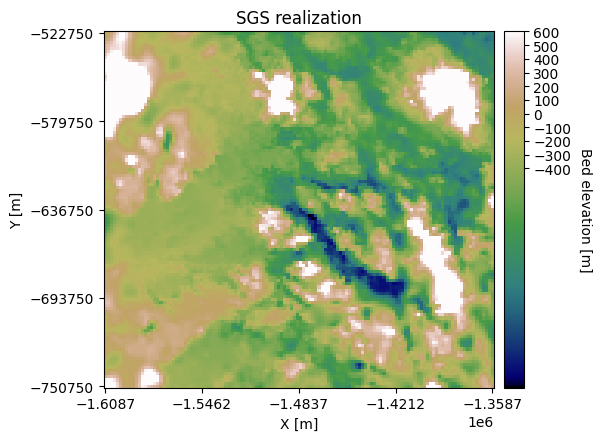

In [13]:
# plot simulation
x_mat = pred_grid[:,0].reshape((rows, cols))
y_mat = pred_grid[:,1].reshape((rows, cols))
sgs_mat = sim_trans.reshape((rows, cols))

fig, ax = plt.subplots(figsize=(6, 5))

im = ax.pcolormesh(x_mat, y_mat, sgs_mat, vmin=-2000, vmax=600, cmap='gist_earth')
ax.set_title('SGS realization')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

ax.set_xticks(np.linspace(xmin, xmax, 5))
ax.set_yticks(np.linspace(ymin, ymax, 5))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(im, ticks=np.linspace(-400, 600, 11), cax=cax)
cbar.set_label("Bed elevation [m]", rotation=270, labelpad=15)

ax.axis('scaled')

plt.tight_layout()
plt.show()

Load in your BedMachine data and plot the topography for this region.

NOTICE! The categorical data in bedmachine will automatically be interpolated using nearest neighbor interpolation method


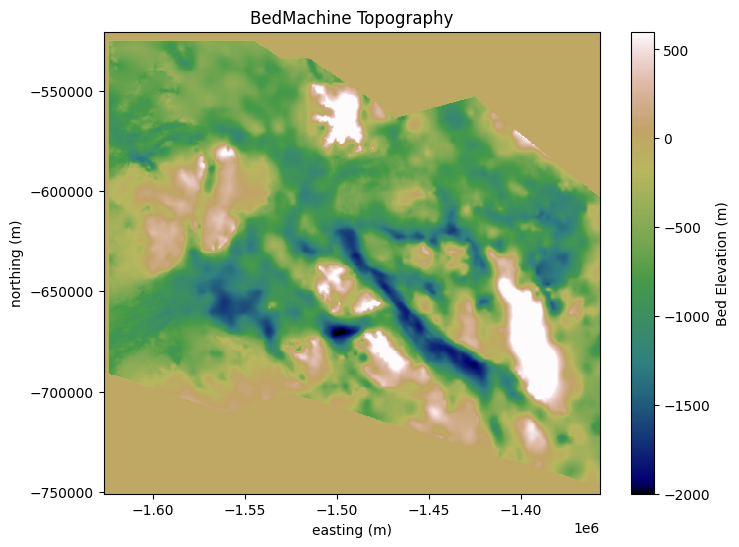

In [14]:
import os
import Topography
from matplotlib.path import Path
from matplotlib.patches import Polygon as MplPolygon
from scipy.interpolate import griddata
df = pd.read_csv('../data/KohlerPopeSmith.csv')

# Use code form lab 1 to load bedmachine bed data
xmin, xmax, ymin, ymax = -1626750, -1356750, -750750, -520250
resolution = 500
xx, yy = np.meshgrid(np.arange(xmin, xmax, resolution), 
                     np.arange(ymin, ymax, resolution))
bm_mask, bm_source, bm_bed, bm_surface, bm_errbed, figbm = Topography.load_bedmachine('../data/BedMachineAntarctica-v3.nc', xx, yy, resolution)
poly_kps = [(-1624250, -525250), (-1544250, -525250), (-1530250, -533750), (-1515250, -533750), (-1475250, -557750), (-1468102, -563551),  
            (-1425250, -552750), (-1356039, -603747), (-1356039, -747750), (-1525250, -700750), (-1560839, -710812), (-1624250, -690812)]
mpl_poly_kps = MplPolygon(poly_kps, closed=True, edgecolor="red", facecolor="none", lw=2)
mask_kps = Path(poly_kps).contains_points(np.vstack((xx.flatten(), yy.flatten())).T).astype(int)
df['bedmachine_bed'] = bm_bed.flatten() * mask_kps
df = df.dropna(subset=['x', 'y', 'bedmachine_bed'])

# Get arrays from DataFrame
x = df['x'].values
y = df['y'].values
bed = df['bedmachine_bed'].values

# Create a grid
xi = np.linspace(x.min(), x.max(), 500)
yi = np.linspace(y.min(), y.max(), 500)
X, Y = np.meshgrid(xi, yi)
Z = griddata((x, y), bed, (X, Y), method='linear')

# plot topography
plt.figure(figsize=(8,6))
c = plt.pcolormesh(X, Y, Z, vmin=-2000, vmax=600, cmap='gist_earth')
plt.colorbar(c, label='Bed Elevation (m)')
plt.xlabel('easting (m)')
plt.ylabel('northing (m)')
plt.title('BedMachine Topography')
plt.show()

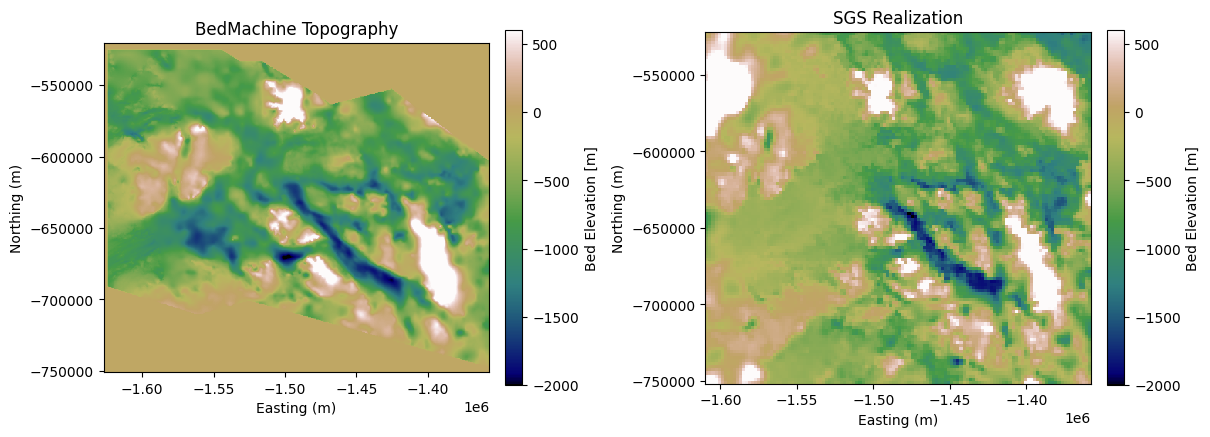

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# BedMachine
im1 = axs[0].pcolormesh(X, Y, Z, vmin=-2000, vmax=600, cmap='gist_earth', shading='auto')
axs[0].set_title('BedMachine Topography')
axs[0].set_xlabel('Easting (m)')
axs[0].set_ylabel('Northing (m)')
axs[0].set_aspect('equal', 'box')
cbar1 = plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
cbar1.set_label('Bed Elevation [m]')

# SGS
im2 = axs[1].pcolormesh(x_mat, y_mat, sgs_mat, vmin=-2000, vmax=600, cmap='gist_earth', shading='auto')
axs[1].set_title('SGS Realization')
axs[1].set_xlabel('Easting (m)')
axs[1].set_ylabel('Northing (m)')
axs[1].set_aspect('equal', 'box')
cbar2 = plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
cbar2.set_label('Bed Elevation [m]')

plt.show()


__Q4: Visually, how does your simulated topography compare to BedMachine? Why do they differ?__

Answer: The simulated topography looks very similar to the BedMachine bed elevation. However, there are some key differences. For example, the area below Kohler glacier (the dark blue band) in BedMachine appears to be one larger area of high elevation. However, the SGS simluation splits this area up into mutliple smaller areas of high elevation. This is a consequence of the physical realism that SGS imposes on the topography. While this is also the goal of BedMachine, SGS appears to do this on a higher level. Thhis could also be a result of the resolution of the SGS simulation being smaller and the SGS graph looking more pixelated as a result. Another thing to note is that there is an area in the left of the BedMachine figure that has areas of low bed elevation that is missed by the SGS. 

## Variogram comparison

Now you are going to compare the variograms for BedMachine and your simulation. Compute the experimental variograms for both BedMachine and your simulated (back-transformed) topography. Plot the two experimental variograms.

NOTICE! The categorical data in bedmachine will automatically be interpolated using nearest neighbor interpolation method


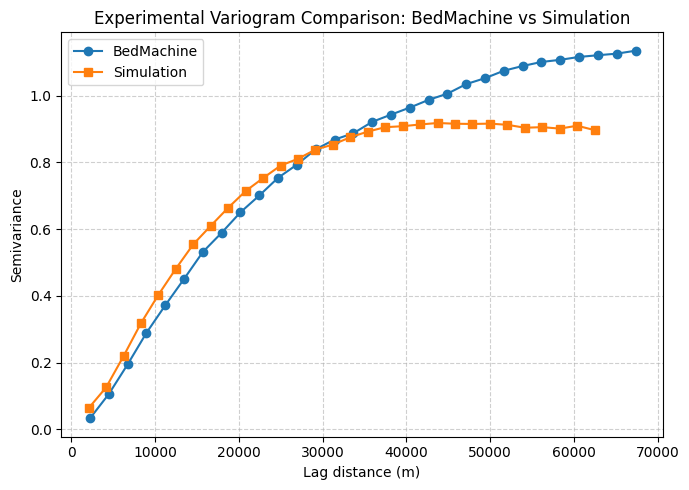

In [22]:
# Use code form lab 1 to load bedmachine bed data
xmin, xmax, ymin, ymax = -1626750, -1356750, -750750, -520250
resolution = 500
xx, yy = np.meshgrid(np.arange(xmin, xmax, resolution), 
                     np.arange(ymin, ymax, resolution))
bm_mask, bm_source, bm_bed, bm_surface, bm_errbed, figbm = Topography.load_bedmachine('../data/BedMachineAntarctica-v3.nc', xx, yy, resolution)
poly_kps = [(-1624250, -525250), (-1544250, -525250), (-1530250, -533750), (-1515250, -533750), (-1475250, -557750), (-1468102, -563551),  
            (-1425250, -552750), (-1356039, -603747), (-1356039, -747750), (-1525250, -700750), (-1560839, -710812), (-1624250, -690812)]
mpl_poly_kps = MplPolygon(poly_kps, closed=True, edgecolor="red", facecolor="none", lw=2)
mask_kps = Path(poly_kps).contains_points(np.vstack((xx.flatten(), yy.flatten())).T).astype(int)
df['bedmachine_bed'] = bm_bed.flatten() * mask_kps
df = df.dropna(subset=['x', 'y', 'bedmachine_bed'])

# Get BedMachine bed data for Kohler, Pope, and Smith specifically
bedmachine_bed = bm_bed.flatten() * mask_kps

# Create DataFrame and sample
df_bedmachine = pd.DataFrame({
    'x': xx.flatten(),
    'y': yy.flatten(),
    'bedmachine_bed': bedmachine_bed
}).dropna(subset=['bedmachine_bed'])
df_bedmachine_sampled = df_bedmachine.sample(frac=0.03, random_state=42)

# Normal score transform
data_bed = df_bedmachine_sampled['bedmachine_bed'].values.reshape(-1, 1)
nst_bed = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(data_bed)
df_bedmachine_sampled['Nbed'] = nst_bed.transform(data_bed)

coords_bed = df_bedmachine_sampled[['x', 'y']].values
values_bed = df_bedmachine_sampled['Nbed']

maxlag = np.ptp(coords_bed, axis=0).max() * 0.25
n_lags = 30

V_bedmachine = skg.Variogram(
    coords_bed, values_bed,
    bin_func='even', 
    n_lags=n_lags, 
    maxlag=maxlag, 
    normalize=False
)

# Create df for SGS variogram
df_sim = pd.DataFrame({
    'x': pred_grid[:, 0],
    'y': pred_grid[:, 1],
    'bed': sim_trans
})

# Normal score transform
data_sim = df_sim['bed'].values.reshape(-1, 1)
nst_sim = QuantileTransformer(n_quantiles=500, output_distribution='normal').fit(data_sim)
df_sim['Nbed'] = nst_sim.transform(data_sim)

df_sim_sampled = df_sim.sample(frac=0.35, random_state=42)

coords_sim = df_sim_sampled[['x', 'y']].values
values_sim = df_sim_sampled['Nbed']

maxlag = np.ptp(coords_sim, axis=0).max() * 0.25

V_sim = skg.Variogram(
    coords_sim, values_sim,
    bin_func='even', 
    n_lags=n_lags, 
    maxlag=maxlag, 
    normalize=False
)

# Plot variograms
plt.figure(figsize=(7, 5))
plt.plot(V_bedmachine.bins, V_bedmachine.experimental, 'o-', color='tab:blue', label='BedMachine')
plt.plot(V_sim.bins, V_sim.experimental, 's-', color='tab:orange', label='Simulation')
plt.title('Experimental Variogram Comparison: BedMachine vs Simulation')
plt.xlabel('Lag distance (m)')
plt.ylabel('Semivariance')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


__Q5: How do the experimental variograms differ? How do you interpret these differences?__

Answer: The experimental variograms are initally similar, but as the lag grows, the SGS variogram levels off while the BedMachine variogram keeps increasing. This means that the SGS model captures local variability well, but does not caputre large scale trends that BedMachine might. 